In [ ]:
# Menggunakan Kaggle API
! chmod 600 /content/kaggle.json

In [ ]:
# Mendownload Dataset (Disimpan di folder 'content')
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d techsash/waste-classification-data

 99% 425M/427M [00:14<00:00, 28.0MB/s]
100% 427M/427M [00:14<00:00, 30.8MB/s]


In [ ]:
# Mengekstrak file (Disimpan di folder 'tmp')
import zipfile
zip_file = zipfile.ZipFile('/content/waste-classification-data.zip')
zip_file.extractall('/tmp/')

In [ ]:
# Menempatkan direktori training dan validation
import os
base_dir = '/tmp/DATASET/'
train_dir = os.path.join(base_dir, 'TRAIN')
val_dir = os.path.join(base_dir, 'TEST')

# Direktori dengan gambar training sampah organik
train_o_dir = os.path.join(train_dir, 'O')

# Direktori dengan gambar training sampah daur ulang
train_r_dir = os.path.join(train_dir, 'R')

# Direktori dengan gambar validation sampah organik
val_o_dir = os.path.join(val_dir, 'O')

# Direktori dengan gambar validation sampah daur ulang
val_o_dir = os.path.join(val_dir, 'R')

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop

def create_model():
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150,150,3)),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  model.compile(loss='binary_crossentropy',
                optimizer=RMSprop(learning_rate=1e-4),
                metrics=['accuracy'])
  return model

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescale
train_data = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_data = ImageDataGenerator(rescale=1./255)

train_generator = train_data.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=200,
    class_mode='binary'
)

val_generator = val_data.flow_from_directory(
    val_dir,
    target_size=(150,150),
    batch_size=100,
    class_mode='binary'
)

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [ ]:
EPOCHS = 20
model = create_model()

history = model.fit(
    train_generator,
    steps_per_epoch=113,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=26,
    verbose=2)

Epoch 1/20
113/113 - 167s - loss: 0.5601 - accuracy: 0.7340 - val_loss: 0.3653 - val_accuracy: 0.8715 - 167s/epoch - 1s/step
Epoch 2/20
113/113 - 156s - loss: 0.4594 - accuracy: 0.7922 - val_loss: 0.3520 - val_accuracy: 0.8711 - 156s/epoch - 1s/step
Epoch 3/20
113/113 - 154s - loss: 0.4454 - accuracy: 0.7987 - val_loss: 0.3525 - val_accuracy: 0.8707 - 154s/epoch - 1s/step
Epoch 4/20
113/113 - 154s - loss: 0.4340 - accuracy: 0.8063 - val_loss: 0.3544 - val_accuracy: 0.8679 - 154s/epoch - 1s/step
Epoch 5/20
113/113 - 153s - loss: 0.4241 - accuracy: 0.8120 - val_loss: 0.3517 - val_accuracy: 0.8631 - 153s/epoch - 1s/step
Epoch 6/20
113/113 - 153s - loss: 0.4175 - accuracy: 0.8150 - val_loss: 0.3778 - val_accuracy: 0.8500 - 153s/epoch - 1s/step
Epoch 7/20
113/113 - 150s - loss: 0.4099 - accuracy: 0.8181 - val_loss: 0.3584 - val_accuracy: 0.8559 - 150s/epoch - 1s/step
Epoch 8/20
113/113 - 150s - loss: 0.4035 - accuracy: 0.8212 - val_loss: 0.3591 - val_accuracy: 0.8552 - 150s/epoch - 1s/step


In [ ]:
import matplotlib.pyplot as plt

def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

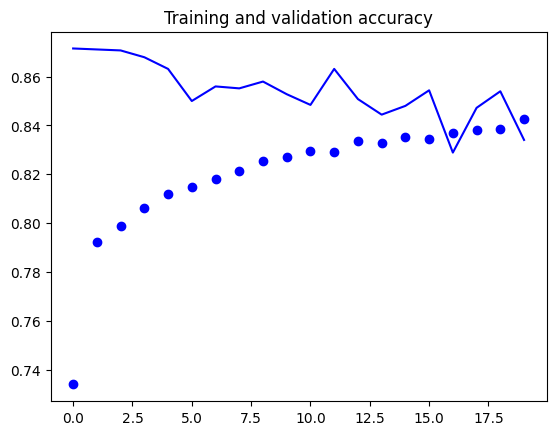

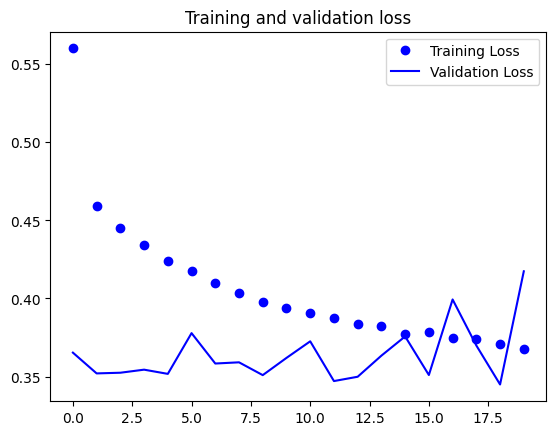

In [ ]:
plot_loss_acc(history)

In [ ]:
export_dir = 'saved_model/1'
tf.saved_model.save(model, export_dir)

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [ ]:
import pathlib
tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)

169954364